[  0.82721749  19.34362126 -15.91513279]
[  0.97627199  30.98807107 -30.26798627]


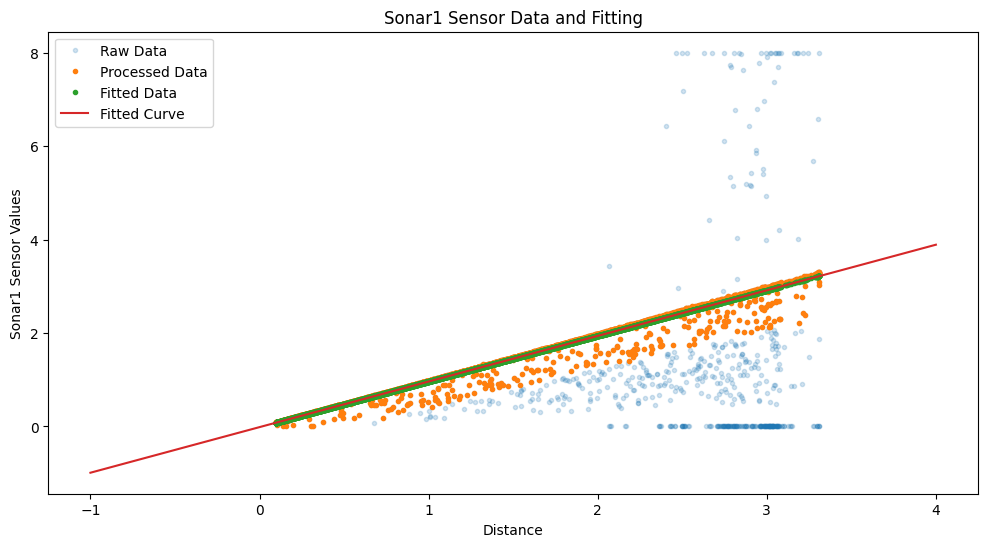

In [1]:
# Import necessary libraries
import scipy as sp
import Model.IR_model as mm
from numpy import loadtxt, gradient
matplotlib.style.use('default')
import matplotlib.pyplot as plt
import numpy as np

# Load data from a CSV file
filename = 'partA/training1.csv'
data = loadtxt(filename, delimiter=',', skiprows=1)

# Split the data into columns
index, time, distance, velocity_command, raw_ir1, raw_ir2, raw_ir3, raw_ir4, \
    sonar1, sonar2 = data.T

# Perform data filtering using a custom function (sn1_model)
# This is the first filtering
sn1_x, sn1_v, sn1_fit, sn1_params = mm.remove_outlier(mm.sn1_model, distance, sonar1, 0.7)
print(sn1_params)

# Define a custom function sn1_model
def sn1_model(x, a, b, c):
    return a * (x + b) + c

# Fit the filtered data using the sn1_model and optimize.curve_fit
filtered_params, cov = sp.optimize.curve_fit(sn1_model, sn1_x, sn1_fit)
filtered_fit = sn1_model(sn1_x, *filtered_params)
print(filtered_params)

# Extract parameters from the fitted model
sn1_a = filtered_params[0]
sn1_b = filtered_params[1]
sn1_c = filtered_params[2]

# Define the inverse function H_INV_sn1
def H_INV_sn1(v):
    return (v - sn1_c) / sn1_a - sn1_b

# Create a plot to visualize the original data, filtered data, and fitted curve
plt.figure(figsize=(12, 6))
plt.plot(distance, sonar1, '.', alpha=0.2, label='Raw Data')
plt.plot(sn1_x, sn1_v, '.', label='Processed Data')
plt.plot(sn1_x, sn1_fit, '.', label='Fitted Data')
x_values = np.linspace(-1, 4, 100)
plt.plot(x_values, sn1_model(x_values, *filtered_params), label='Fitted Curve')

# Add labels, legends, and title
plt.xlabel('Distance')
plt.ylabel('Sonar1 Sensor Values')
plt.legend()
plt.title('Sonar1 Sensor Data and Fitting')

# Display the plot
plt.show()


## liklihood function

In [2]:
import numpy as np

# Function to calculate the derivative of a given function 'func' at point 'x'
def diff(func, x):
    dx = 0.001
    return (func(x + dx) - func(x)) / dx

# Function to invert 'sensor_model' to find 'curguess' such that 'sensor_model(curguess)' is close to 'z'
def H_invert(sensor_model, z, scope=(0, 10)):
    half = (scope[1] - scope[0]) / 2
    curguess = scope[1] / 2
    lim = 0
    maxLim = 1000
    
    while (np.abs(sensor_model(curguess) - z) > 0.0001 and lim < maxLim):
        lim += 1
        if sensor_model(curguess) > z:
            if diff(sensor_model, curguess) > 0:  # If positive slope
                curguess -= half / 2
            else:
                curguess += half / 2
        else:
            if diff(sensor_model, curguess) > 0:  # If positive slope
                curguess += half / 2
            else:
                curguess -= half / 2
        half /= 2

    if np.abs(sensor_model(curguess) - z) > 0.0001:
        return None
    else:
        return curguess

# Function to find two guesses using 'invertH' within specified range 'scope'
def amb_H_invert(sensor_model, z, mid, scope=(0, 4)):
    guess = H_invert(sensor_model, z, scope=(0, mid))
    guess2 = H_invert(sensor_model, z, scope=(mid, 4))
    return guess, guess2

<function H_INV_sn1 at 0x1677ada80>
1.9373779296875
2.000035219957823


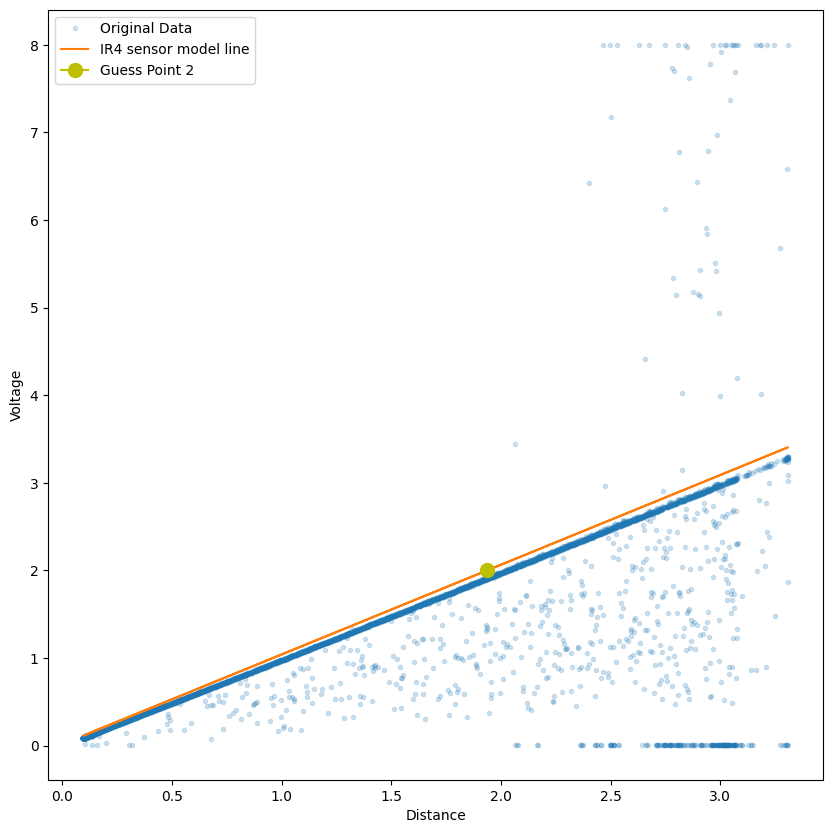

In [3]:
# Set the current 'z' value or target value

Vol_z = 2  # Use a specific value of 'z'
H_sensor_model = H_INV_sn1# Use the 'h_ir4' sensor model
print(H_sensor_model)

# Calculate two guesses ('gus1' and 'gus2') for the inversion of 'H_sensor_model' at 'cur_z'
gPoint1, gPoint2 = amb_H_invert(H_sensor_model, Vol_z, mid=1)
# print(gus1)

# Create a figure for plotting
plt.figure(figsize=(10, 10))
# plt.figure(figsize=(4, 3), dpi=150)

# Plot the original data points for IR4 with a label
plt.plot(distance, sonar1, '.', alpha=0.2, label='Original Data')

# Plot the curve generated by 'H_sensor_model' with a label
plt.plot(distance, H_sensor_model(distance), '-', label='IR4 sensor model line')

# Plot the guessed points ('gus1' and 'gus2') on the curve with labels and larger markers
try:
    plt.plot(gPoint1, H_sensor_model(gPoint1), '-bo', markersize=10, label='Guess Point 1')
    print(gPoint1)
    print(H_sensor_model(gPoint1))
except:
    pass

try:
    plt.plot(gPoint2, H_sensor_model(gPoint2), '-yo', markersize=10, label='Guess Point 2')
    print(gPoint2)
    print(H_sensor_model(gPoint2))
except:
    pass

# Add labels for the x-axis and y-axis
plt.xlabel("Distance")
plt.ylabel("Voltage")

# Add a legend
plt.legend()



In [4]:
def VarError_LookUpTable(x, error, xstep=0.3):
    """
    Calculate the mean and variance of error values based on a lookup table.

    Args:
        x (array): Array of lengths.
        error (array): Array of fitting curve error values.
        xstep (float): Step size for partitioning the data. Defaults to 0.1.

    Returns:
        tuple: Three arrays containing x-axis values, mean error values, and variance of error values.
    """
    x_now = xstep
    curbar = np.array([])

    x_mu = np.array([])
    std_x = np.array([])
    xaxis = np.array([])

    for i in range(0, len(x)):
        
        if (x[i] < x_now):
            
            curbar = np.append(curbar, error[i])
        else:
            error_std = np.std(curbar)
            error_mean = np.mean(curbar)
            x_mu = np.append(x_mu, error_mean)
            std_x = np.append(std_x, error_std)
            xaxis = np.append(xaxis, x[i])
            curbar = np.array([])
            x_now += xstep
    
    return xaxis, x_mu, std_x


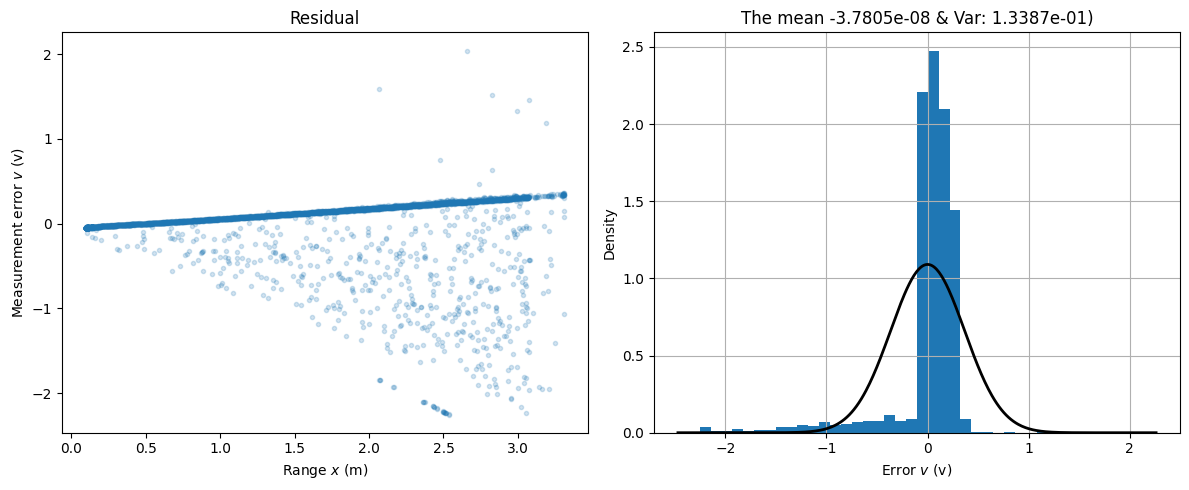

[  0.82721749  19.34362126 -15.91513279]


In [5]:
import Model.IR_model as mm
sn1_x, sn1_v,sn1_fit,sn1_params= mm.remove_outlier(mm.sn1_model,distance,sonar1,3)
sn1_mu, sn1_std,sn1_error = mm.Residual_and_Histogram(sn1_x,sn1_v,sn1_fit)




# err = 
print(sn1_params)

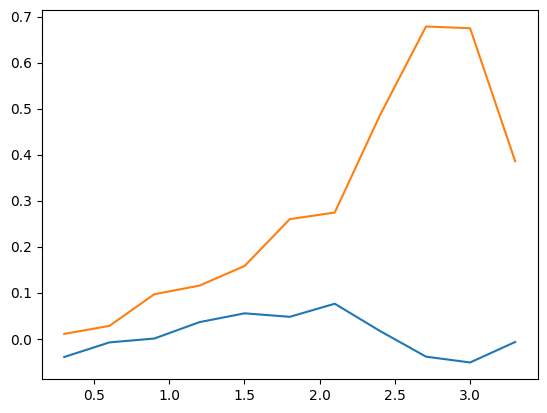

In [6]:
Xaxis_sn1, Mu_X_sn1, std_X_sn1 = VarError_LookUpTable(sn1_x,sn1_error,0.3)
''' Input: x, error, step  '''
# plt.figure()
plt.plot(Xaxis_sn1,Mu_X_sn1)
plt.plot(Xaxis_sn1,std_X_sn1)
# print(Xaxis_sn1)

ir4 1 guess 1.9373779296875


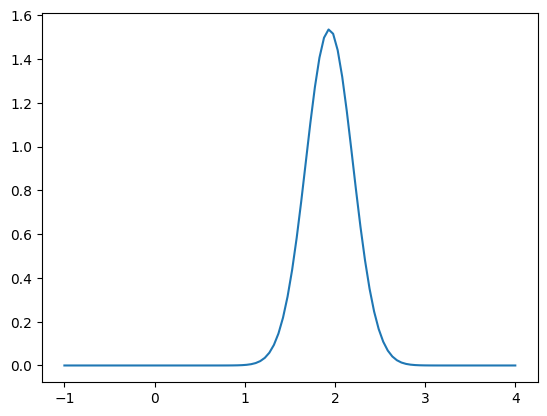

In [12]:
from scipy import stats
# gPoint2, gPoint1 = amb_H_invert(H_sensor_model, Vol_z, mid=1)
gPoint = H_invert(H_sensor_model, Vol_z, scope=(1, 4))

def find_std_index(value, intervals):
    """
    根据给定的值和区间，找到该值所在的区间索引。

    参数：
    - value：要查找区间的值。
    - intervals：包含区间的NumPy数组。假定区间是已排序的。

    返回：
    - interval_index：值所在的区间索引。如果值小于第一个区间下限，返回0。
      如果值大于最后一个区间上限，返回len(intervals) - 1。
    """
    if value < intervals[0]:
        return 0
    if value >= intervals[-1]:
        return len(intervals) - 1
    for i in range(len(intervals) - 1):
        if value >= intervals[i] and value < intervals[i + 1]:
            return i
    return -1  # 如果值不在任何区间内，则返回-1


gPoint_index = find_std_index(gPoint, Xaxis_sn1)


gPoint_std = std_X_sn1[gPoint_index]



# Debug section
if not gPoint is None:
    L_sn1 = stats.norm.pdf(x_values, loc=gPoint1, scale=(gPoint_std))
    print(f"ir4 1 guess {gPoint}")
    ir41Plot = plt.plot(x_values, L_sn1)
else:
    ir41Plot = plt.plot()





Closest x value: 1.894736842105263
Corresponding h(x) value: 1.9563577530397893


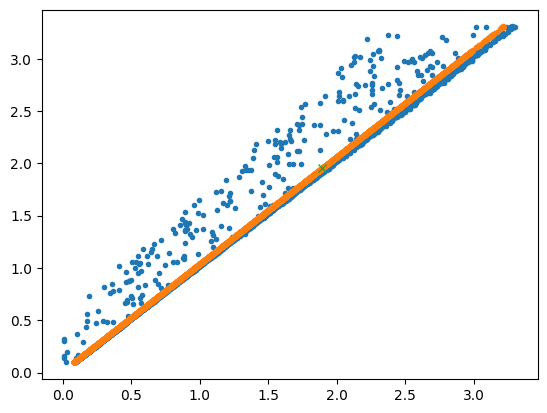

In [ ]:
from scipy.optimize import brute



def h_inverse(z, xmin, xmax, step=0.01, tolerance=0.001):
    def error_function(x, z):
        return abs(H_INV_sn1(x) - z)

    result = brute(error_function, ((xmin, xmax),), args=(z,), full_output=True, finish=None)

    return result[0]  # Access the estimated x value directly

# 示例用法
z = 2  # Your target value
xmin = 0  # Minimum value in the range
xmax = 4  # Maximum value in the range

result = h_inverse(z, xmin, xmax)
print("Closest x value:", result)
print("Corresponding h(x) value:", H_INV_sn1(result))


plt.plot(sn1_v,sn1_x,'.')
plt.plot(sn1_fit,sn1_x,'.')
plt.plot(result, H_INV_sn1(result),'x')

In [ ]:
# print(findIndex2(2,sonar1))